# Mission 2 

In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import konlpy as kp 

In [2]:
df1 = pd.read_csv('배달의_민족_기업평가.csv')

In [3]:
# df1 데이터를 이용해 아래의 미션을 수행하고자 한다 
# 1) '작성시간'데이터를 '작성시간_dt'변수로 날짜데이터로 변환하여 선언 
df1['작성시간_dt'] = pd.to_datetime(df1['작성시간'])

In [4]:
# 2) '재직여부'에서 '전직원'들이 가장 많이 리뷰를 남긴 연도를 확인 
df1['작성연도'] = df1['작성시간_dt'].dt.year

cond1 = (df1['재직여부']=='전직원')
df1.loc[cond1]['작성연도'].value_counts()

2019    32
2018    27
2017    15
2016     8
2020     5
2015     3
Name: 작성연도, dtype: int64

In [5]:
# 3) '직종'중 가장 빈도수가 높은 2 직종을 추출하여, 
#    df1_top으로 선언한 뒤, df1_top 에서 '한줄평'에 대한 '명사'를 워드클라우드로 시각화 
#    -> image.png 파일로 저장 
work_order_list = df1['직종'].value_counts().index.tolist()

cond1   = df1['직종'].isin(work_order_list[:2])
df1_top = df1.loc[cond1]

In [6]:
# 시리즈 -> 형태소 분석 
def pos_dataframe(data):
    okt = kp.tag.Okt()
    df_POS = pd.DataFrame()
    for i in range(0, len(data)):
        dfn = pd.DataFrame( okt.pos(data.values.tolist()[i]) )
        df_POS = pd.concat([df_POS, dfn])
    return df_POS.rename(columns={0:'형태소',1:'품사'})

In [7]:
df_Pos = pos_dataframe(df1_top['한줄평'])
cond1 = (df_Pos['품사']=='Noun')
df_N  = df_Pos.loc[cond1]

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

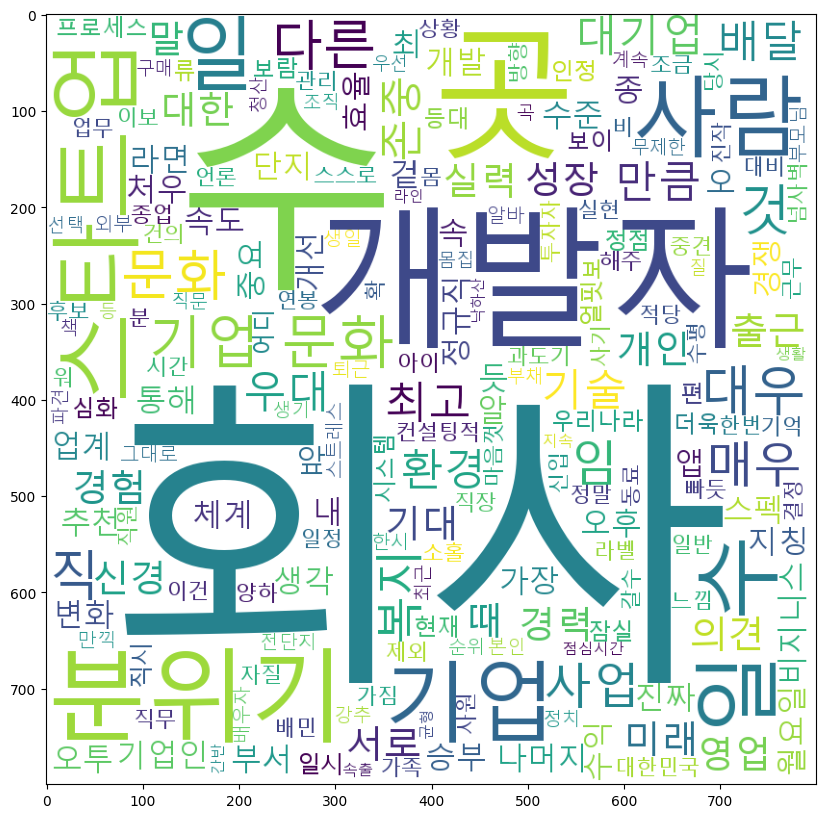

<Figure size 640x480 with 0 Axes>

In [9]:
wc_img = WordCloud(background_color='white', width=800, height=800,
                  font_path='Malgun.ttf').generate(' '.join(df_N['형태소']))
plt.figure(figsize=[10,10])
plt.imshow(wc_img)
plt.show()
plt.savefig('img_wc.png')

In [10]:
# - company_Train_data.csv 데이터를 불러와 아래의 미션을 수행하고자 한다. 
# 1) 해당 데이터를 df3로 불러와, 한줄평에 따른 '기업성장여부'를 분류하는 분류모델을 구성
df3 = pd.read_csv('company_Train_data.csv')

In [11]:
Y = df3['기업성장여부'].replace({'성장':1, '정체':0})
X = df3[['한줄평']]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [14]:
# 불용어 처리함수 
import re
def text_remove_stopword(i):
    review_text = re.sub('[!1+(),.@#2345]?\n', "", i)
    word_text = kp.tag.Okt().morphs(review_text, stem=True)
    return word_text

In [15]:
X_train_list = [] 
X_test_list  = []

In [16]:
for i in X_train['한줄평']:
    if type(i)==str:
        X_train_list.append(text_remove_stopword(i))
    else:
        X_train_list.append( [] )
        
for i in X_test['한줄평']:
    if type(i)==str:
        X_test_list.append(text_remove_stopword(i))
    else:
        X_test_list.append( [] )

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# Text to Seq / Padding 
tts_Vec = Tokenizer()
tts_Vec.fit_on_texts(X_train_list)

train_Seq = tts_Vec.texts_to_sequences(X_train_list)
test_Seq  = tts_Vec.texts_to_sequences(X_test_list)

In [19]:
train_input = pad_sequences(train_Seq, padding='post', maxlen=50)
test_input  = pad_sequences(test_Seq, padding='post', maxlen=50)

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [21]:
model_pipe = make_pipeline(RobustScaler(), GradientBoostingClassifier())
hyper_parameter = {} 
grid_model = GridSearchCV(model_pipe, param_grid=hyper_parameter, cv=5, n_jobs=-1)
grid_model.fit(train_input, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1, param_grid={})

In [22]:
best_model = grid_model.best_estimator_

In [23]:
import pickle
pickle.dump(best_model, open('model_nlp.sav','wb'))

In [24]:
# 3) company_Test_data.csv를 불러와 df3_test로 선언한뒤, 앞서 만든 모델에 넣어 
#    '기업성장여부'를 분류하고, 분류된 '기업성장여부' 빈도수 확인 
df3_test = pd.read_csv('company_Test_data.csv')  

In [25]:
def input_nlp_preprocess(data): 
    X_new_list = [] 
    for i in data['한줄평']:
        if type(i)==str:
            X_new_list.append( text_remove_stopword(i) )
        else:
            X_new_list.append( [] )

    new_seq   = tts_Vec.texts_to_sequences(X_new_list)
    new_input = pad_sequences(new_seq, padding='post', maxlen= 50) 
    return new_input

In [26]:
new_input = input_nlp_preprocess(df3_test[['한줄평']])

In [27]:
df3_test['분류값'] = best_model.predict(new_input)

<AxesSubplot:xlabel='분류값', ylabel='count'>

c:\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  func(*args, **kwargs)
c:\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  func(*args, **kwargs)
c:\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  func(*args, **kwargs)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canva

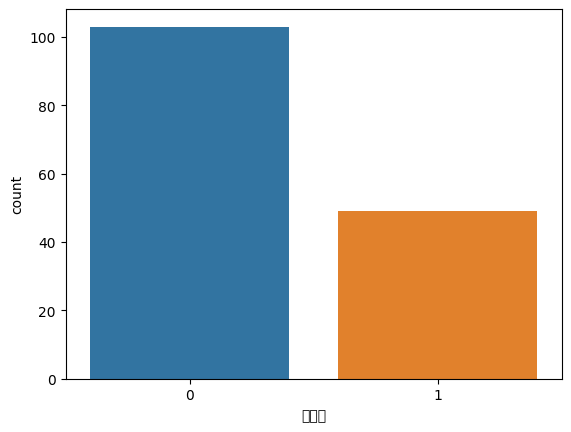

In [28]:
sns.countplot(data=df3_test, x='분류값')

In [29]:
df3_test['분류값'].value_counts()

0    103
1     49
Name: 분류값, dtype: int64

# 텍스트 유사도 

- 서로 비슷한 텍스트가 얼마나 유사한지를 표현 
- 문장의 구조는 다르지만 의미가 같은 경우 / 동의어를 사용해 문장이 구성된 경우 
- 네트워크 분석 : 단어간의 유사성 (연관분석 / 특정 단어가 같이 등장할 확률) /시각화
- 신경망 분석   : 판별모델에서 Encoder 구성 / 생성모델에서 Transfomer 구성 

In [30]:
# networkx : 네트워크 분석 시각화 라이브러리 / apyori : 연관분석   
# !pip install --user networkx  
# !pip install --user apyori 

In [31]:
# 네트워크 분석 
# 형태소 분석 -> 유사도 계산 -> 네트워크 시각화 
df3['한줄평']

0      1. 내부구성원들을 위하는 기업문화가 형성되어있고, 실제로 운영측면에서도 배려마인드...
1      그 누구의 눈치도 보지 않으며, 자유로운 의사소통에 내부 분위기, 팀별로 케바케 이...
2                 도서구입비 무제한 지원, 주 35시간 근무, 월요일은 오후1시 출근,
3      자율적인 분위기와 좋은 복지를 많이 갖춘 곳. 좋은 사람들이 많이 모여있고 그 안에...
4      1. 내부구성원들을 위하는 기업문화가 형성되어있고, 실제로 운영측면에서도 배려마인드...
                             ...                        
299    딱히 없음. 회사가 좋아서 여기 있다가 이직하실때 오히려 다른 회사에 적응못할 수있...
300    대기업처럼 체계적으로 시스템이 많이 갖추어지지는 않았어요. 그래서 지금 열심히 만들...
301                        로테이션 근무\n교육 커리큘럼의 체계가 잡혀있지 않음
302    아이티는 어쩔수 없다. 업무량대폭발. !!!! 그래도 야근은 종종 철야는 아주아주 ...
303                           편하게 놀거라고 생각하고 오면 당황할 수 있다.
Name: 한줄평, Length: 304, dtype: object

In [32]:
# 불용어 파일 불러와 처리 
df_stopword  = pd.read_csv('stopword.txt', header=None, names=['불용어'])
stopword_set = set(df_stopword['불용어'].values.tolist())

In [33]:
# 불용어 처리함수 
def text_remove_stopword(i):
    review_text = re.sub('[!1+(),.@#2345]?\n', "", i)
    word_text = kp.tag.Okt().morphs(review_text, stem=True)
    word_text2 = [ tk for tk in word_text if not tk in stopword_set ]
    return word_text2

In [34]:
clean_word = [] 
for i in df3['한줄평']:
    if type(i)==str: 
        clean_word.append( text_remove_stopword(i) )
    else : 
        clean_word.append( [] )

In [35]:
import apyori

In [36]:
# 지지도 Support : 전체 데이터에서 A와 B 가 동시에 포함된 비율 
result_apy  = apyori.apriori(clean_word, min_support = 0.03)
df_support  = pd.DataFrame(list(result_apy))

In [37]:
df_support['count'] = df_support['items'].apply( lambda x : len(x))

In [38]:
cond1 = (df_support['count']==2)
df_network = df_support.loc[cond1]

In [39]:
import networkx as nx 

In [40]:
graph_model = nx.Graph()
pr          = nx.pagerank(graph_model)
graph_model.add_edges_from(df_network['items'])

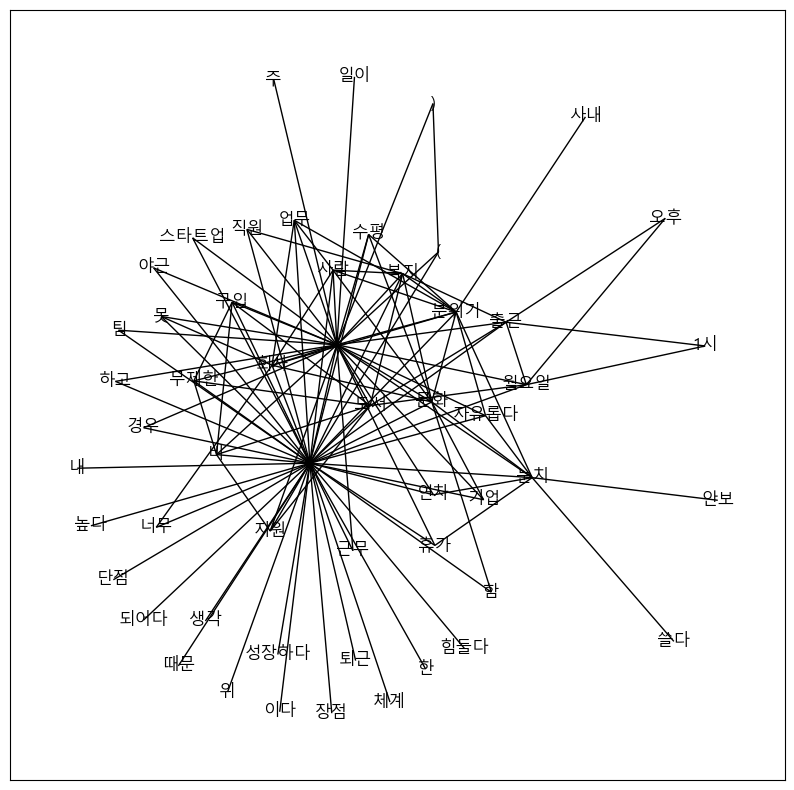

In [41]:
grp = nx.kamada_kawai_layout(graph_model)
plt.figure(figsize=[10,10])
nx.draw_networkx(graph_model, font_family='Malgun Gothic',
                 pos = grp, 
                 node_color=list(pr.values()))

# 신경망 알고리즘 활용해 분류모델 구성 

In [42]:
!pip install --user keras 

In [43]:
import tensorflow 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, SGD
from keras.utils import to_categorical

In [44]:
# Y 값에 대한 Matrix 구성 
Y_matrix = to_categorical(Y_train)

In [45]:
# Model 구성
model1 = Sequential()
model1.add(layers.Embedding(1600, 32, input_length = 50 ))
model1.add(layers.SimpleRNN(32)),
model1.add(layers.Dense(2, activation='sigmoid'))
model1.summary()

model1.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics= ['acc'])

history1 = model1.fit(train_input, Y_matrix, epochs=40, batch_size=32,
                      validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            51200     
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 53,346
Trainable params: 53,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
6/6 [==============================] - 5s 187ms/step - loss: 0.6966 - acc: 0.4670 - val_loss: 0.6845 - val_acc: 0.6087
Epoch 2/40
6/6 [==============================] - 1s 126ms/step - loss: 0.6071 - acc: 0.8352 - val_loss: 0.6797 - val_acc: 0.5217
Epoch 3/40
6/6 [==============================] - 1s 116

In [46]:
df_score = pd.DataFrame()
df_score['ACC'] = history1.history['acc']
df_score['Loss'] = history1.history['loss']
df_score['val_ACC'] = history1.history['val_acc']
df_score['val_Loss'] = history1.history['val_loss']
df_score2 = df_score.reset_index()

<AxesSubplot:xlabel='index', ylabel='ACC'>

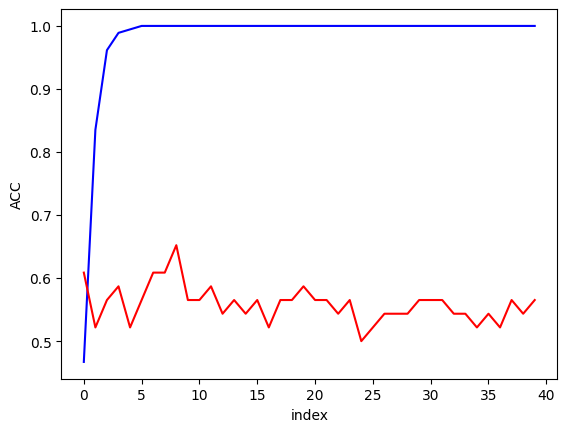

In [47]:
sns.lineplot(data=df_score2, x='index', y='ACC', color='b')
sns.lineplot(data=df_score2, x='index', y='val_ACC' , color='r')

<AxesSubplot:xlabel='index', ylabel='Loss'>

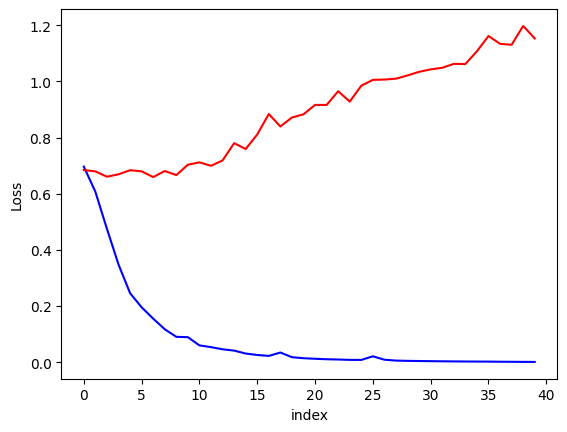

In [48]:
sns.lineplot(data=df_score2, x='index', y='Loss', color='b')
sns.lineplot(data=df_score2, x='index', y='val_Loss' , color='r')

1. **RNN** 
- Recurrent Neural Network (RNN): 순서를 갖는 (Sequence) 데이터를 학습 / 처리 
- Node (Unit)에서 처리된 정보를 'State' 로 저장하여 앞/뒤 정보를 유지하며 학습 (순환연결) 
- 한계 : 긴 문장(Sequence)이 오게되면 이전에 처리되었던 state를 적절하게 유지하기 어려움 
    - Vanishing Gradient (기울기 소실) : Layer가 많은 신경망 알고리즘에서 주로 발생 
    - 신경망 앞쪽에 있는 Layer의 Weight가 적절하게 Update 되지 못함 
    - 오차(Loss)가 더 이상 줄어들지 않고 특정 값에 Weight값이 고정   
    
2. **LSTM (Long Short Term Memory)**
- Vanishing Gradient (기울기 소실)의 문제를 개선하기 위해, 앞선 Node(Unit)처리된 정보를 지속적으로 유지할 수 있는 한의 **State Node**를 구성하여 학습
    - 순환 드롭 아웃 : Overfitting 방지 
    - 스태킹 Layer   : Layer 연산 강화 (Cost 비용) 
    - 양방향 순환 Layer : 같은 정보를 다른 방향으로 주입하여 학습 

3. **GRU(Gated Recurrent Unit)**
    - LSTM 불필요한 구조를 제거 한 형태의 신경망 알고리즘 
    - 순환 드롭 아웃 : Layer 내 연산을 수행하는 Node(Unit)를 랜덤으로 건너뛰어 연산 
        - LSTM 연산의 량은 줄이고, 과적합도 방지 할 수 있지만, 성능이 개선되지는 않음
        - 모든 Unit 내에 동일한 Drop Out 적용 

**LSTM**

In [49]:
model2 = Sequential() # Layer를 구성하기위한 공간을 객체로 선언 
model2.add(layers.Embedding(1600, 64, input_length= 50 ))
model2.add(layers.LSTM(32))
model2.add(layers.Dense(2, activation='sigmoid'))
model2.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model2.summary()

history = model2.fit(train_input, Y_matrix, epochs=40, batch_size=32,
                      validation_split = 0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            102400    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 114,882
Trainable params: 114,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
6/6 [==============================] - 4s 145ms/step - loss: 0.6931 - acc: 0.5110 - val_loss: 0.6977 - val_acc: 0.4348
Epoch 2/40
6/6 [==============================] - 0s 32ms/step - loss: 0.6917 - acc: 0.5659 - val_loss: 0.6985 - val_acc: 0.4348
Epoch 3/40
6/6 [==============================] - 0s 

In [50]:
def score_df(model):
    df_score = pd.DataFrame()
    df_score['ACC'] = history.history['acc']
    df_score['Loss'] = history.history['loss']
    df_score['val_ACC'] = history.history['val_acc']
    df_score['val_Loss'] = history.history['val_loss']
    df_score2 = df_score.reset_index()
    return df_score2

In [51]:
def eval_plot(df_score2):
    sns.lineplot(data=df_score2, x='index', y='ACC', color='b')
    sns.lineplot(data=df_score2, x='index', y='val_ACC' , color='r')
    sns.lineplot(data=df_score2, x='index', y='Loss', color='g')
    sns.lineplot(data=df_score2, x='index', y='val_Loss' , color='y')

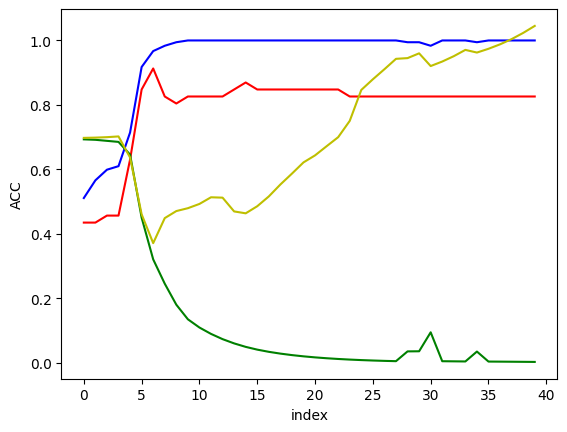

In [52]:
df_lstm_score = score_df(history)
eval_plot(df_lstm_score)

**GRU**

In [53]:
model3 = Sequential() # Layer를 구성하기위한 공간을 객체로 선언 
model3.add(layers.Embedding(1600, 64, input_length= 50 ))
model3.add(layers.GRU(32))
model3.add(layers.Dense(2, activation='sigmoid'))
model3.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model3.summary()

history = model3.fit(train_input, Y_matrix, epochs=40, batch_size=32,
                      validation_split = 0.3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 64)            102400    
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 111,874
Trainable params: 111,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
5/5 [==============================] - 3s 166ms/step - loss: 0.6927 - acc: 0.5220 - val_loss: 0.6982 - val_acc: 0.4493
Epoch 2/40
5/5 [==============================] - 0s 35ms/step - loss: 0.6916 - acc: 0.5472 - val_loss: 0.7018 - val_acc: 0.4348
Epoch 3/40
5/5 [==============================] - 0s 

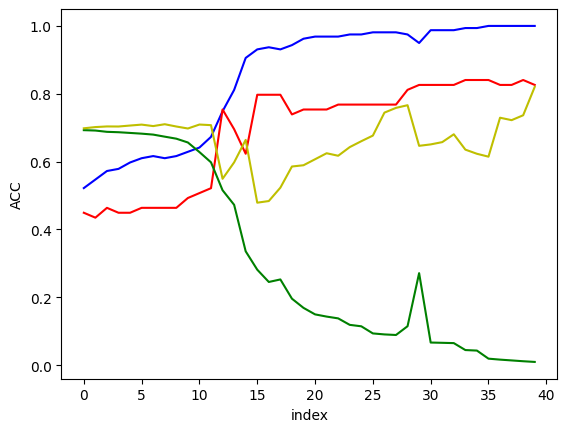

In [54]:
df_lstm_score = score_df(history)
eval_plot(df_lstm_score)

**Stacking Recurrent Layer**

In [55]:
model4 = Sequential()
model4.add(layers.Embedding(1600, 64, input_length= 50))
model4.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model4.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.5))
model4.add(layers.Dense(2, activation='sigmoid'))

model4.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model4.summary()
history = model4.fit(train_input, Y_matrix, epochs=40, batch_size=32,
                      validation_split = 0.3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 64)            102400    
                                                                 
 gru_1 (GRU)                 (None, 50, 32)            9408      
                                                                 
 gru_2 (GRU)                 (None, 64)                18816     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 130,754
Trainable params: 130,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
5/5 [==============================] - 11s 1s/step - loss: 0.6940 - acc: 0.4654 - val_loss: 0.6962 - val_acc: 0.4058
Epoch 2/40
5/5 [==============================] - 5s

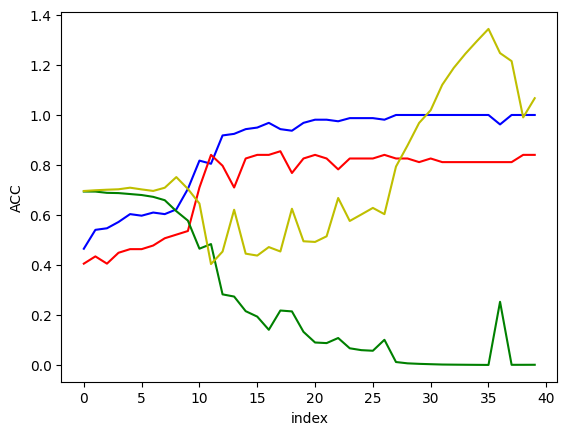

In [56]:
df_lstm_score = score_df(history)
eval_plot(df_lstm_score)

**BERT**

- Bidirectional Encoder Representations from Transformers
- **Encoder**를 탑재하고있는 모델 
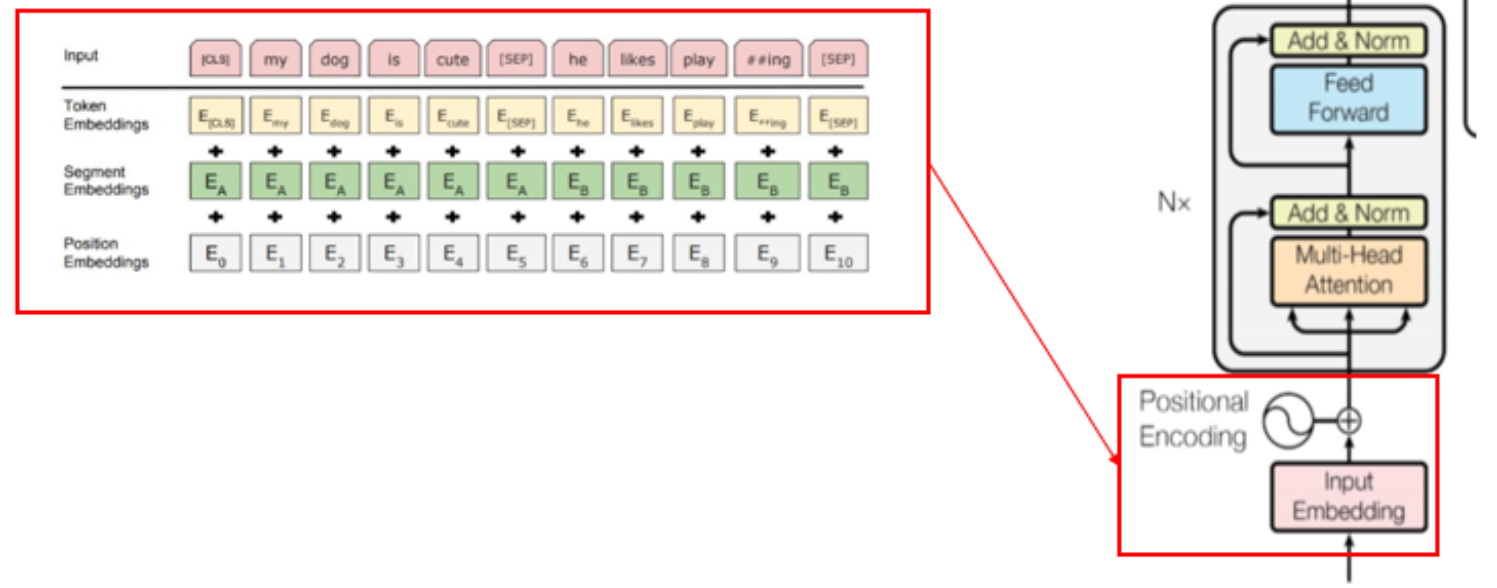

- Transformer : **Encoder**(언어 -> 컴퓨터) + Decoder (컴퓨터 -> 언어) (생성모델)  

**구성**

0. WordPiece : 문장 내 단어에 대한 Tokenizing + Padding / 빈도수가 낮은 단어를 서브 워드로 분리하여 분석 
    -> I am rewriting the posts 
    -> [i , am, rewriting, the, posts]
    -> [i , am, re, ##write, ##ing, the, posts, ##s ]
    -> 더 정확한 문맥 파악 / 본래 단어 복원 쉽게 진행 

1. Contextual Embedding : 단어 앞/뒤에 태그를 부착하여, 순차적으로 벡터와 하여 문맥이 반영되게 끔 임베딩 

2. Self Attention : 임베딩으로 벡터화된 단어들을 이용해 유사도를 계산하는 함수 
    (유사도가 반영된 가중함수를 연산 / 행렬 연산 + 활성 함수) 
    
3. Pre-Training : 사전 학습 
    - 양방향으로 문맥의 모든 단어를 참조하여 예측하는 형태 
    - MLM (Masked Language Model) + Next Sentence Prediction (NSP) 
    - Masked Language Model : 입력받은 문장의 일부를 Random Masking -> 모델이 문맥을 통해 본래의 단어를 예측하도록 구성 (문장 내 단어 처리)
    - Next Sentence Prediction (NSP) : 두개의 문장이 서로 이어지는 문장인지를 판별 
       (문장 간 처리) 

4. Fine-Tuninig : 사전학습된 모델에 일부 데이터만 추가로 학습하여 모델을 구성 방식 

In [57]:
import tensorflow as tf 
import torch

In [58]:
df1 = pd.read_csv('company_Train_data.csv')
df1['Target'] = df1['기업성장여부'].replace({'성장':1, '정체':0})

In [59]:
X = df1[['한줄평']]
Y = df1['Target'].values

In [60]:
# Contextual Embedding 사전 작업 / [CLS] + [SEP]
X_contextual = '[CLS] '+ X + ' [SEP]'

In [61]:
# !pip insatll --user transformers

In [62]:
# WordPiece 
from transformers import BertTokenizer

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                           do_lower_case=False)

In [64]:
X_tarin_list = [ ]
for i in range(0, len(X_contextual)):
    word_piece = tokenizer.tokenize( X_contextual.values.tolist()[i][0] )
    X_tarin_list.append(word_piece)

In [65]:
# Padding
X_sequence = [ ]
for k in range(0, len(X_tarin_list)):
    token_seq = tokenizer.convert_tokens_to_ids(X_tarin_list[k])
    X_sequence.append(token_seq) # id 값만 부여 
    
print(pd.DataFrame(X_sequence).shape) # 가장 긴 문장에 맞춰서 Padding 

X_padding =  pad_sequences(X_sequence, maxlen=300, padding='post')

(304, 300)


In [66]:
# Attention Mask [1,23,40, 0,0,0,0,0,0] 
# 패딩작업의 결과로 생성된 불필요한 0 값을 구분지어주는 리스트를 형성 
X_atmask = [ ]
for j in X_padding:
    X_atmask.append( [float(k>0) for k in j ] ) 
    # 단어가 있는 부분은 1 / 없는 부분은 0 
    # 불필요한 0 값을 학습에 제외하고 학습을 수행하기 위해 at mask 제작 

In [67]:
# 학습데이터 검증데이터 분할 
X_train, X_test, Y_train, Y_test = train_test_split(X_padding, Y, random_state=1234)
# Attenion Mask 분할 
X_train_mask, X_test_mask, _, _ = train_test_split(X_atmask,X_padding,random_state=1234)

In [68]:
# 3가지의 행렬을 하나의 텐서행렬로 병합 ( 패딩된 X / 마스크 X / Y )
X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)
X_train_mask_tensor = torch.tensor(X_train_mask)

X_test_tensor = torch.tensor(X_test)
Y_test_tensor = torch.tensor(Y_test)
X_test_mask_tensor = torch.tensor(X_test_mask)

In [69]:
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [70]:
train_data = TensorDataset(X_train_tensor, X_train_mask_tensor, Y_train_tensor)
validation_data  = TensorDataset(X_test_tensor, X_test_mask_tensor, Y_test_tensor)

In [71]:
train_sampler = RandomSampler(train_data)
validation_sampler  = SequentialSampler(validation_data)

train_dataloader = DataLoader(train_data, sampler= train_sampler, batch_size= 32)
validation_dataloader  = DataLoader(validation_data,  sampler= validation_sampler, batch_size= 32)

**BERT Model 호출 및 학습** 

In [72]:
# Pre Training Model을 호출 
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [73]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=2)
model.cpu( )

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [74]:
# fine-Tuning 
# 최적화 파라미터 설정 
optimizer = AdamW(model.parameters(), lr= 2e-5, eps=1e-8) # lr= 2e-5, eps=1e-8 
epochs = 4 
total_steps = len(train_dataloader) * 4

C:\Users\DMC CONET\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [75]:
# Scheduler  Setting 
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=total_steps)

**학습 수행**

In [76]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [77]:
import random
import time
import datetime

In [79]:
#랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#그래디언트 초기화
model.zero_grad()

# 학습
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
#######################################################################################
    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to('cpu') for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.52
  Training epcoh took: 0:05:18

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:39

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.37
  Training epcoh took: 0:05:10

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:40

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.29
  Training epcoh took: 0:05:11

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:40

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.25
  Training epcoh took: 0:06:59

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:40
